In [5]:
#import basic packages for manipulation and plotting
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# import neural imaging tools
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt
import gif_your_nifti.core as gif2nif

# import ml libs
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)


In [6]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' # original 4 -> converted into 3 later
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include


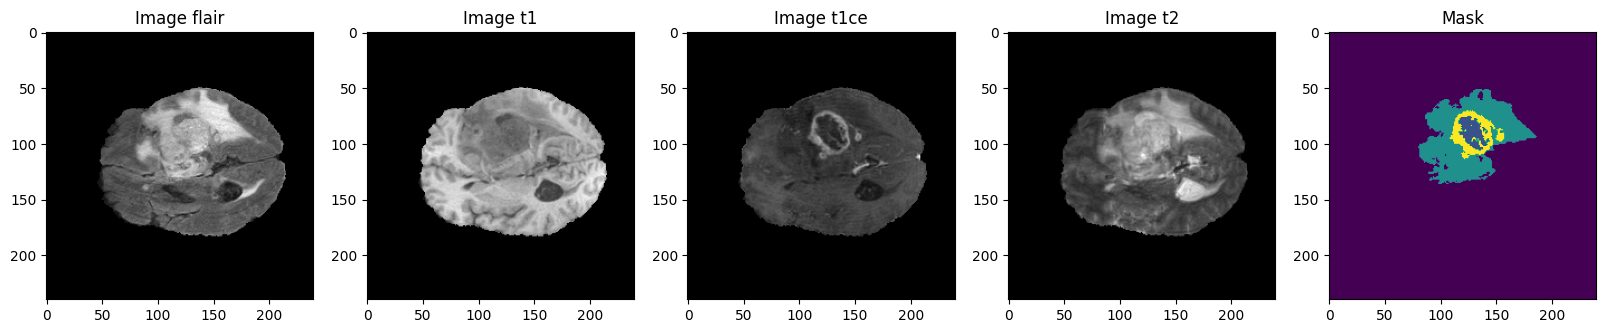

In [7]:
# Set train and validation paths
TRAIN_DATASET_PATH = '/work/users/s/r/sridhark/comp523/523_Brats2020_Split_Data/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = '/work/users/s/r/sridhark/comp523/523_Brats2020_Split_Data/data/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/'

# Visualize sample images
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()

# Plot images, types, and masks
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 50
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')
plt.savefig('slice_viz.pdf', format='pdf')

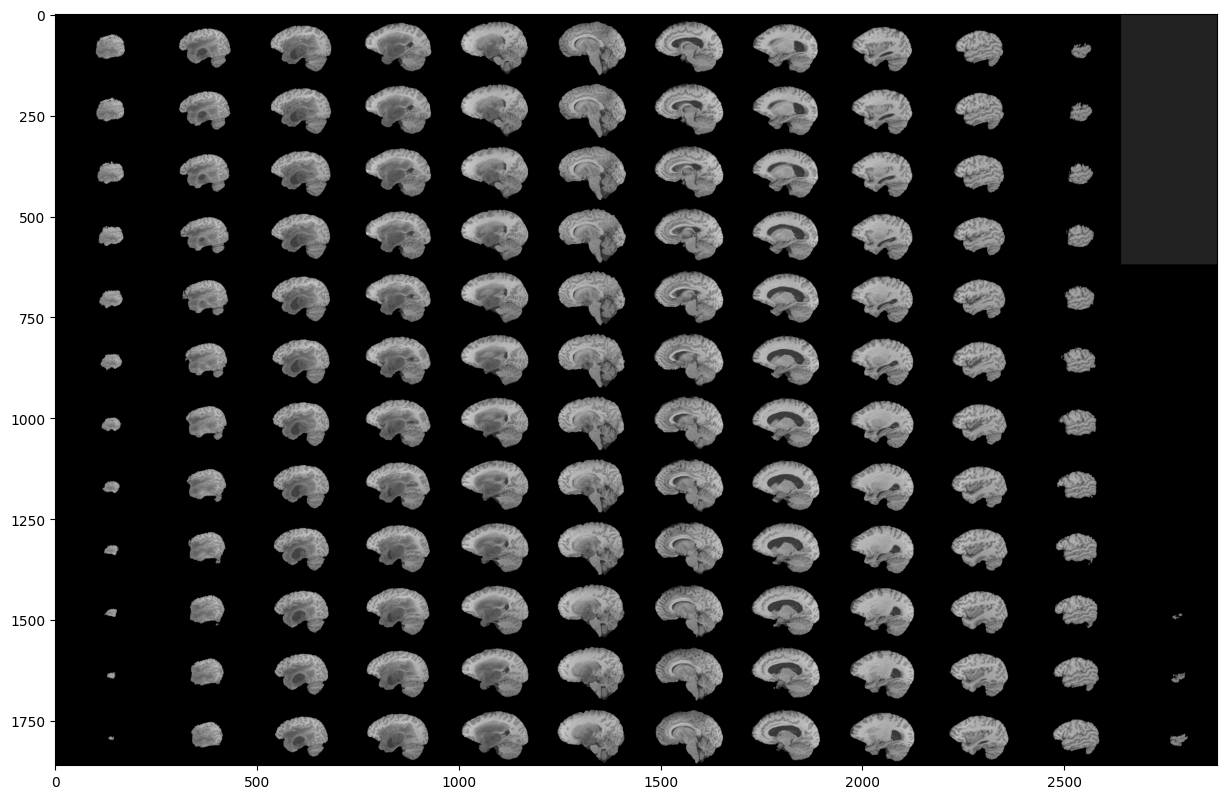

In [8]:
# Visualize slices
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50,:,:]), 90, resize=True), cmap ='gray')

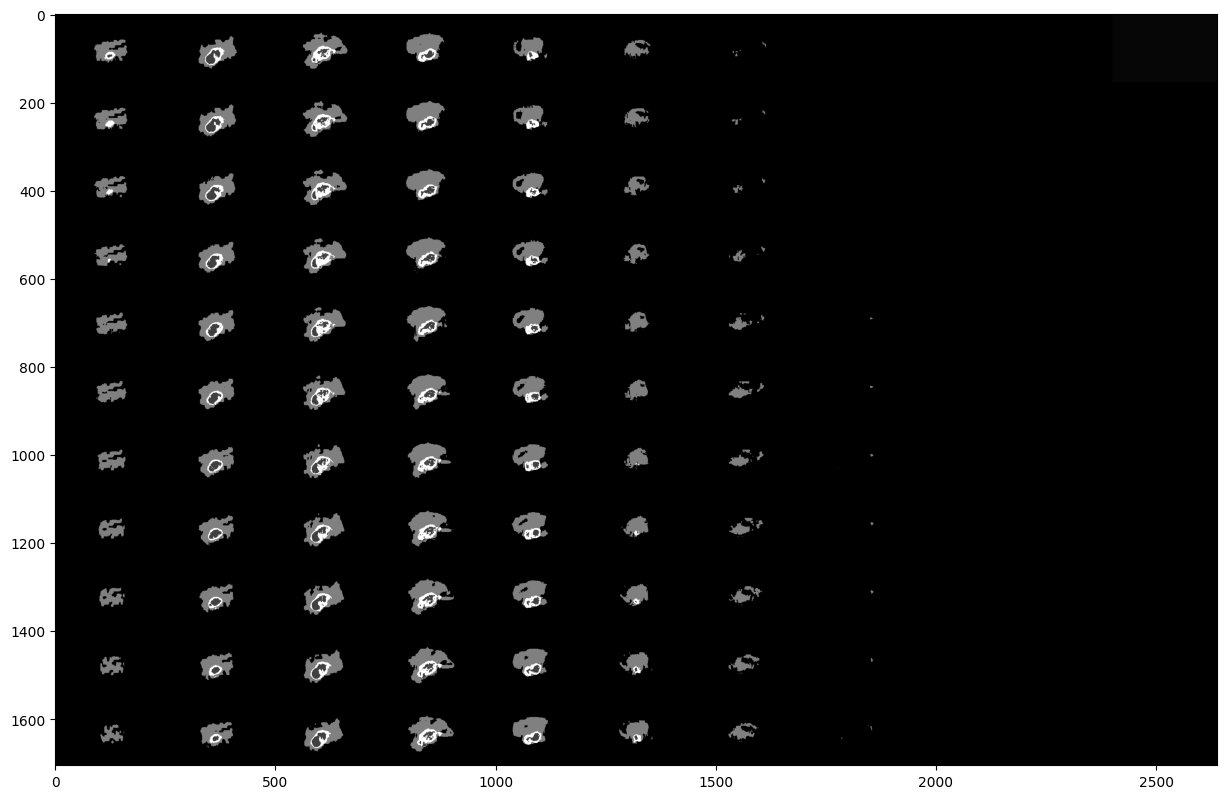

In [9]:
# Visualize Mask
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60,:,:]), 90, resize=True), cmap ='gray')

In [10]:
#gif representation visualization
shutil.copy2(TRAIN_DATASET_PATH + 'BraTS20_Training_006/BraTS20_Training_006_flair.nii', './test_gif_BraTS20_Training_006_flair.nii')
gif2nif.write_gif_normal('./test_gif_BraTS20_Training_006_flair.nii')

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0

In [11]:
# dice loss as defined above for 4 classes
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss


 
# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)



# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


In [12]:
#Set img size according to BRaTS specs
IMG_SIZE=128

In [13]:
#Build UNET Structure
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)
    
    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)
    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)
    
    
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)
    
    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = (2,2))(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)
    
    conv10 = Conv2D(4, (1,1), activation = 'softmax')(conv)
    
    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Keras Compile model
model = build_unet(input_layer, 'he_normal', 0.2)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )


2023-12-05 15:45:09.188235: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38375 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0


In [14]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has improper formatting for seg.nii file, drop data
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')

#Prepare data splits
def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 


In [15]:
#Data Generator Sequence typical to Keras
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))
        Y = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, 4))

        
        # Generate data
        for c, i in enumerate(Batch_ids):
            case_path = os.path.join(TRAIN_DATASET_PATH, i)

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()    

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()
            
            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()
        
            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE));

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT];
                    
        # Generate masks
        y[y==4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (IMG_SIZE, IMG_SIZE));
        return X/np.max(X), Y
        
training_generator = DataGenerator(train_ids)
valid_generator = DataGenerator(val_ids)
test_generator = DataGenerator(test_ids)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


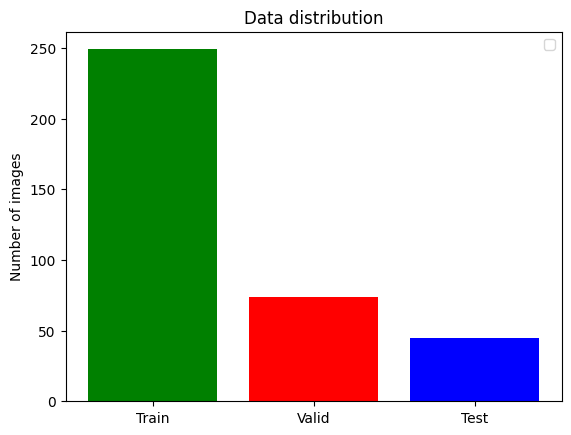

In [16]:
# determine data distribution
def showDataLayout():
    plt.bar(["Train","Valid","Test"],
    [len(train_ids), len(val_ids), len(test_ids)], align='center',color=[ 'green','red', 'blue'])
    plt.legend()

    plt.ylabel('Number of images')
    plt.title('Data distribution')

    plt.show()
    
showDataLayout()


In [17]:
#log training
csv_logger = CSVLogger('training.log', separator=',', append=False)


callbacks = [
      keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001, verbose=1),
        csv_logger
    ]


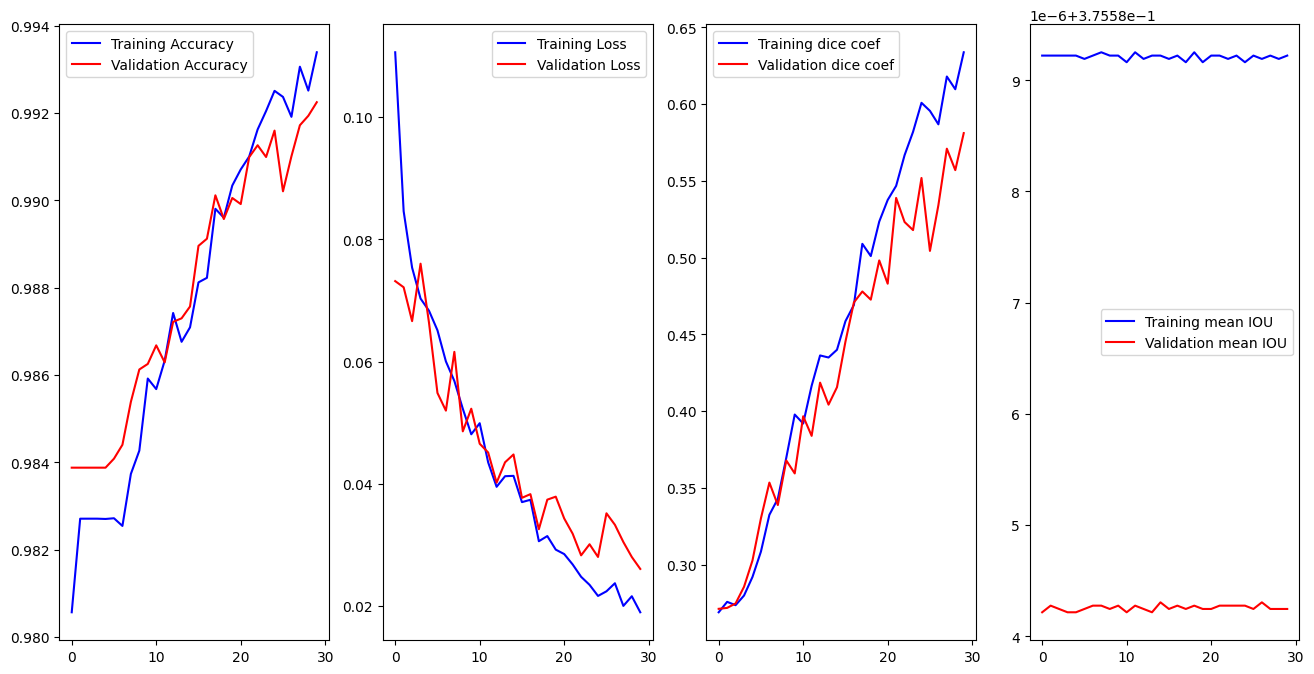

In [18]:
############ load trained model ################
model = keras.models.load_model('/work/users/s/r/sridhark/comp523/model_x2_1.h5', 
                                   custom_objects={ 'accuracy' : tf.keras.metrics.MeanIoU(num_classes=4),
                                                   "dice_coef": dice_coef,
                                                   "precision": precision,
                                                   "sensitivity":sensitivity,
                                                   "specificity":specificity,
                                                   "dice_coef_necrotic": dice_coef_necrotic,
                                                   "dice_coef_edema": dice_coef_edema,
                                                   "dice_coef_enhancing": dice_coef_enhancing
                                                  }, compile=False)

#Load saved model history
history = pd.read_csv('/work/users/s/r/sridhark/comp523/training.log', sep=',', engine='python')

hist=history

############### ########## ####### #######

#Load metrics from log

acc=hist['accuracy']
val_acc=hist['val_accuracy']

epoch=range(len(acc))

loss=hist['loss']
val_loss=hist['val_loss']

train_dice=hist['dice_coef']
val_dice=hist['val_dice_coef']

f,ax=plt.subplots(1,4,figsize=(16,8))

#Plot metrics
ax[0].plot(epoch,acc,'b',label='Training Accuracy')
ax[0].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[0].legend()

ax[1].plot(epoch,loss,'b',label='Training Loss')
ax[1].plot(epoch,val_loss,'r',label='Validation Loss')
ax[1].legend()

ax[2].plot(epoch,train_dice,'b',label='Training dice coef')
ax[2].plot(epoch,val_dice,'r',label='Validation dice coef')
ax[2].legend()

ax[3].plot(epoch,hist['mean_io_u'],'b',label='Training mean IOU')
ax[3].plot(epoch,hist['val_mean_io_u'],'r',label='Validation mean IOU')
ax[3].legend()

plt.show()


2023-12-05 15:45:18.329091: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8801


4/4 [==============================] - 2s 105ms/step


<Figure size 1800x5000 with 0 Axes>

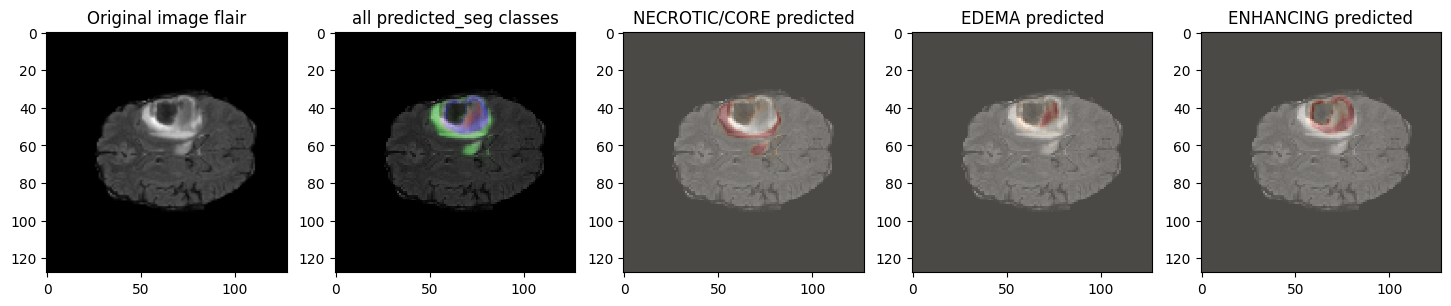

4/4 [==============================] - 0s 10ms/step


<Figure size 1800x5000 with 0 Axes>

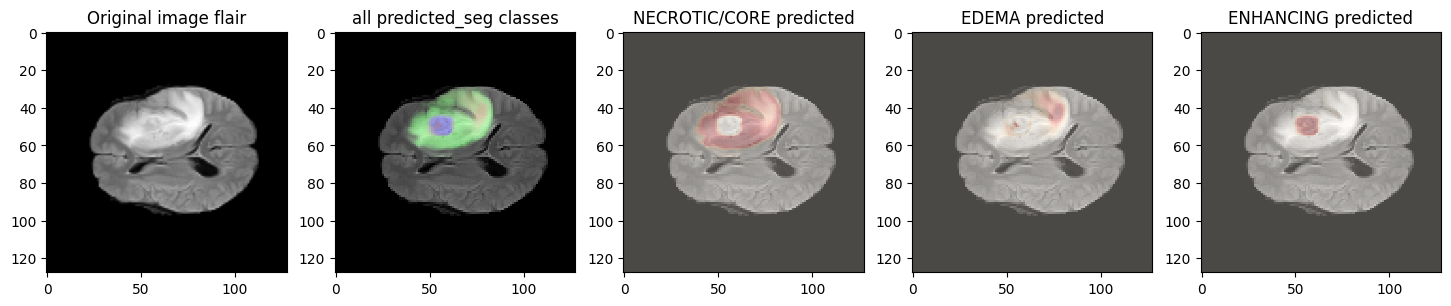

4/4 [==============================] - 0s 10ms/step


<Figure size 1800x5000 with 0 Axes>

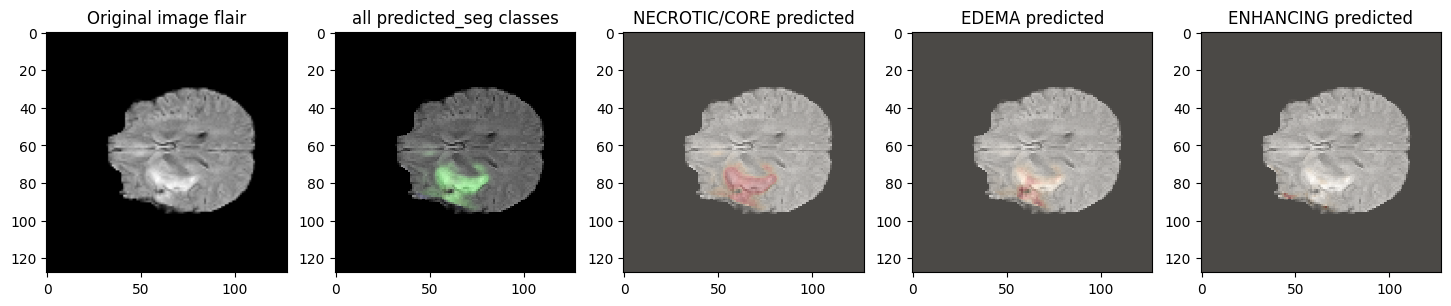

4/4 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

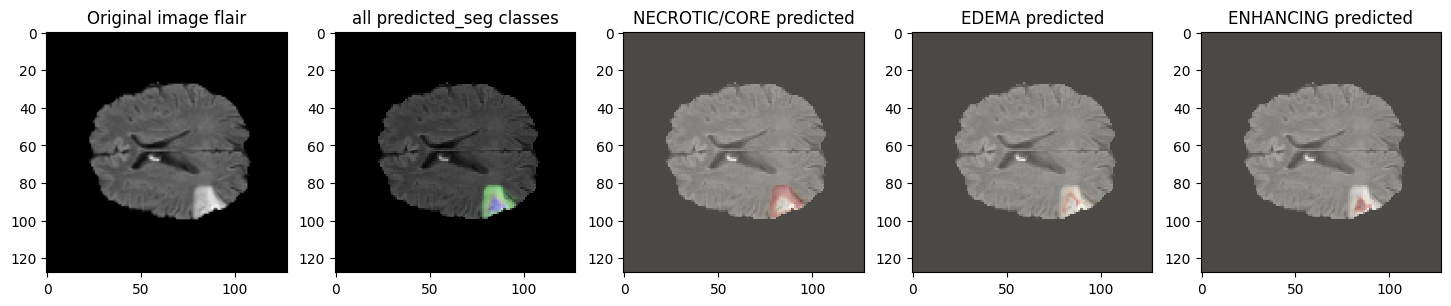

4/4 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

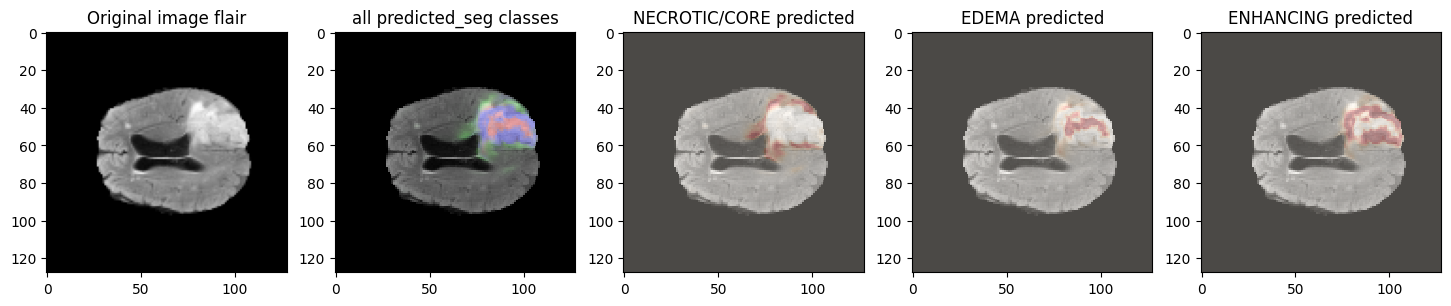

4/4 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

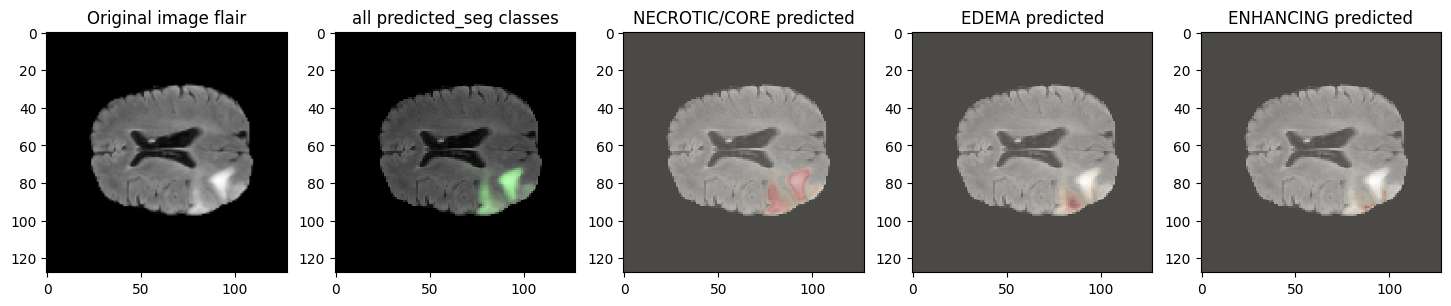

4/4 [==============================] - 0s 15ms/step


<Figure size 1800x5000 with 0 Axes>

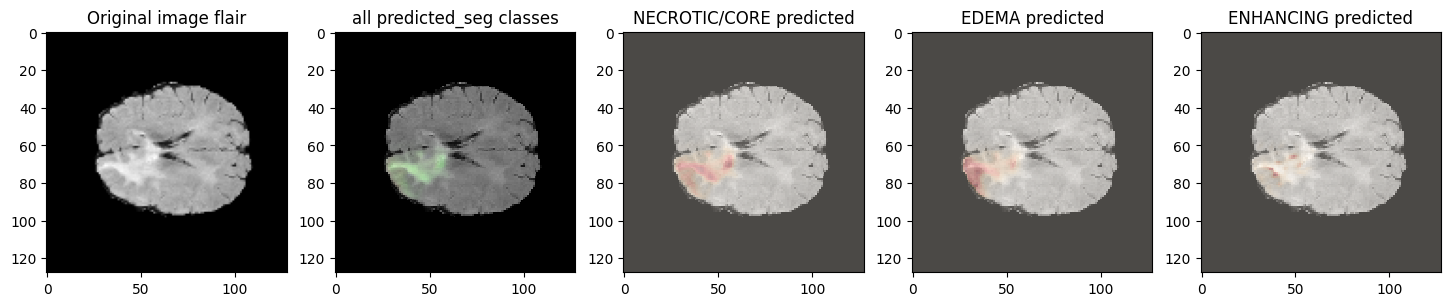

In [19]:
#Sample visualizer of predictions
#Load data in, and list case number. Get flair and t1ce images and compute slices
#Determine prediction from inputs and slices
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()
    
    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata() 
    
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        
    return model.predict(X/np.max(X), verbose=1)

#Visualization driver
def showPredictsById(case, start_slice = 60):
    path = f"/work/users/s/r/sridhark/comp523/523_Brats2020_Split_Data/data/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{case}"
    # gt = nib.load(os.path.join(path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(path,case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,5, figsize = (18, 50)) 

    for i in range(5): # for each image, add brain background
        axarr[i].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray", interpolation='none')
    
    axarr[0].imshow(cv2.resize(origImage[:,:,start_slice+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    axarr[0].title.set_text('Original image flair')
    axarr[1].imshow(p[start_slice,:,:,1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('all predicted_seg classes')
    axarr[2].imshow(edema[start_slice,:,:], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[2].title.set_text(f'{SEGMENT_CLASSES[1]} predicted')
    axarr[3].imshow(core[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{SEGMENT_CLASSES[2]} predicted')
    axarr[4].imshow(enhancing[start_slice,:,], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{SEGMENT_CLASSES[3]} predicted')
    plt.show()
    
#sample segmentation powered by model on sample data
showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[3][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])
showPredictsById(case=test_ids[6][-3:])


In [22]:
#Evaluate best model
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= callbacks)
print("test loss, test acc:", results)

Evaluate on test data


2023-12-04 02:08:37.688651: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:521] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-11.8
  /usr/local/cuda
  /nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.
2023-12-04 02:08:38.945417: W tensorflow/compiler/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:559] libdevice is requ

UnknownError: Graph execution error:

Detected at node Round_5 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/traitlets/config/application.py", line 985, in launch_instance

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_3700240/2182046516.py", line 4, in <module>

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 2272, in evaluate

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 4079, in run_step

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 2042, in test_function

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 2025, in step_function

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 2013, in run_step

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 1896, in test_step

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 1225, in compute_metrics

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state

  File "/tmp/ipykernel_3700240/3652892946.py", line 54, in specificity

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/backend.py", line 3111, in round

Detected at node Round_5 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/traitlets/config/application.py", line 985, in launch_instance

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 737, in start

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 524, in dispatch_queue

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 513, in process_one

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 418, in dispatch_shell

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 758, in execute_request

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 426, in do_execute

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3046, in run_cell

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3101, in _run_cell

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3306, in run_cell_async

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3488, in run_ast_nodes

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code

  File "/tmp/ipykernel_3700240/2182046516.py", line 4, in <module>

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 2272, in evaluate

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 4079, in run_step

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 2042, in test_function

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 2025, in step_function

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 2013, in run_step

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 1896, in test_step

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/training.py", line 1225, in compute_metrics

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 620, in update_state

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/utils/metrics_utils.py", line 77, in decorated

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 140, in update_state_fn

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/metrics/base_metric.py", line 723, in update_state

  File "/tmp/ipykernel_3700240/3652892946.py", line 54, in specificity

  File "/nas/longleaf/home/sridhark/.conda/envs/braintypicality/lib/python3.11/site-packages/keras/src/backend.py", line 3111, in round

2 root error(s) found.
  (0) UNKNOWN:  JIT compilation failed.
	 [[{{node Round_5}}]]
	 [[confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/pivot_f/_3/_13]]
  (1) UNKNOWN:  JIT compilation failed.
	 [[{{node Round_5}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_4987]